# Advanced Tutorial 3: Operator

## Overview
In this tutorial, we will discuss:
* [Operator Mechanism](#ta03om)
    * [data](#ta03data)
    * [state](#ta03state)
* [NumpyOp](#ta03no)
    * [DeleteOp](#ta03do)
    * [LambdaOp](#ta03nl)
    * [Customizing NumpyOps](#ta03cn)
* [TensorOp](#ta03to)
    * [LambdaOp](#ta03tl)
    * [Customizing TensorOps](#ta03ct)
* [Related Apphub Examples](#ta03rae)

<a id='ta03om'></a>

## Operator Mechanism
We learned about the operator structure in [Beginner Tutorial 3](../beginner/t03_operator.ipynb). Operators are used to build complex computation graphs in FastEstimator.

In FastEstimator, all the available data is held in a data dictionary during execution. An `Op` runs when it's `mode` matches the current execution mode. For more information on mode, you can go through [Beginner Tutorial 8](../beginner/t08_mode.ipynb).

Here's one simple example of an operator:

In [1]:
from fastestimator.op.numpyop import NumpyOp

class AddOne(NumpyOp):
    def __init__(self, inputs, outputs, mode = None):
        super().__init__(inputs, outputs, mode)

    def forward(self, data, state):
        x, y = data
        x = x + 1
        y = y + 1
        return x, y
    
AddOneOp = AddOne(inputs=("x", "y"), outputs=("x_out", "y_out"))

An `Op` interacts with the required portion of this data using the keys specified through the `inputs` key, processes the data through the `forward` function and writes the values returned from the `forward` function to this data dictionary using the `outputs` key. The processes are illustrated in the diagram below:

<img src="../resources/t03_advanced_operator_mechanism.png" alt="drawing" width="500"/>

<a id='ta03data'></a>

### data
The data argument in the `forward` function passes the portion of data dictionary corresponding to the Operator's `inputs` into the forward function. If multiple keys are provided as `inputs`, the data will be a list of corresponding to the values of those keys. 

<a id='ta03state'></a>

### state
The state argument in the `forward` function stores meta information about training like the current mode, GradientTape for tensorflow, etc. It is very unlikely that you would need to interact with it.

<a id='ta03no'></a>

## NumpyOp
NumpyOp is used in `Pipeline` for data pre-processing and augmentation. You can go through [Beginner Tutorial 4](../beginner/t04_pipeline.ipynb) to get an overview of NumpyOp and their usage. Here, we will talk about some advanced NumpyOps.

<a id='ta03do'></a>

### DeleteOp
Delete op is used to delete keys from the data dictionary which are no longer required by the user. This helps in improving processing speed as we are holding only the required data in the memory. Let's see its usage:

In [2]:
import fastestimator as fe
from fastestimator.dataset.data import cifar10
from fastestimator.op.numpyop import Delete
from fastestimator.op.numpyop.meta import OneOf, Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, Rotate, VerticalFlip
from fastestimator.op.numpyop.univariate import Blur, Minmax, ChannelTranspose

train_data, eval_data = cifar10.load_data() 

pipeline1 = fe.Pipeline(train_data=train_data,
                        eval_data=eval_data,
                        batch_size=4,
                        ops = [HorizontalFlip(image_in="x", image_out="x_mid", mode="train"), 
                               Rotate(image_in="x_mid", image_out="x", mode="train", limit=45)])

pipeline2 = fe.Pipeline(train_data=train_data,
                        eval_data=eval_data,
                        batch_size=4,
                        ops = [HorizontalFlip(image_in="x", image_out="x_mid", mode="train"), 
                               Rotate(image_in="x_mid", image_out="x", mode="train", limit=45), 
                               Delete(keys="x_mid")])

In [3]:
data1 = pipeline1.get_results()
print("Keys in pipeline: ", data1.keys())

data2 = pipeline2.get_results()
print("Keys in pipeline with Delete Op: ", data2.keys())

Keys in pipeline:  dict_keys(['x', 'y', 'x_mid'])
Keys in pipeline with Delete Op:  dict_keys(['x', 'y'])


<a id='ta03nl'></a>

### LambdaOp
The `LambdaOp` is a flexible Op which allows you to execute arbitrary lambda functions. This can be especially useful for adding new keys to the data dictionary, or for performing simple computations without having to write a new NumpyOp. If your lambda function has a return value, it should be in the form of an np.ndarrary.

In [4]:
from fastestimator.op.numpyop import LambdaOp

pipeline3 = fe.Pipeline(train_data=train_data,
                        eval_data=eval_data,
                        batch_size=4,
                        ops = [LambdaOp(fn=lambda: 5, outputs="z"), #create a new key
                               LambdaOp(fn=lambda a: a*3, inputs="z", outputs="z3")
                               ])

In [5]:
data3 = pipeline3.get_results()
print(f"z: {data3['z']}")
print(f"z3: {data3['z3']}")

z: tensor([5, 5, 5, 5])
z3: tensor([15, 15, 15, 15])


<a id='ta03cn'></a>

### Customizing NumpyOps
We can create a custom NumpyOp which suits our needs. Below, we showcase a custom NumpyOp which creates multiple random patches (crops) of images from each image.

In [6]:
from albumentations.augmentations.transforms import RandomCrop
import numpy as np

class Patch(NumpyOp):
    def __init__(self, height, width, inputs, outputs, mode = None, num_patch=2):
        super().__init__(inputs, outputs, mode)
        self.num_patch = num_patch
        self.crop_fn = RandomCrop(height=height, width=width, always_apply=True)

    def forward(self, data, state):
        image, label = data
        image = np.stack([self._gen_patch(image) for _ in range(self.num_patch)], axis=0)
        label = np.array([label for _ in range(self.num_patch)])
        return [image, label]
    
    def _gen_patch(self, data):
        data = self.crop_fn(image=data)
        return data["image"].astype(np.float32)

Let's create a pipeline and visualize the results.

In [7]:
pipeline4 = fe.Pipeline(train_data=train_data,
                        eval_data=eval_data,
                        batch_size=8,
                        ops=[Minmax(inputs="x", outputs="x"),
                             Patch(height=24, width=24, inputs=["x", "y"], outputs=["x_out", "y_out"], 
                                   num_patch=4)])

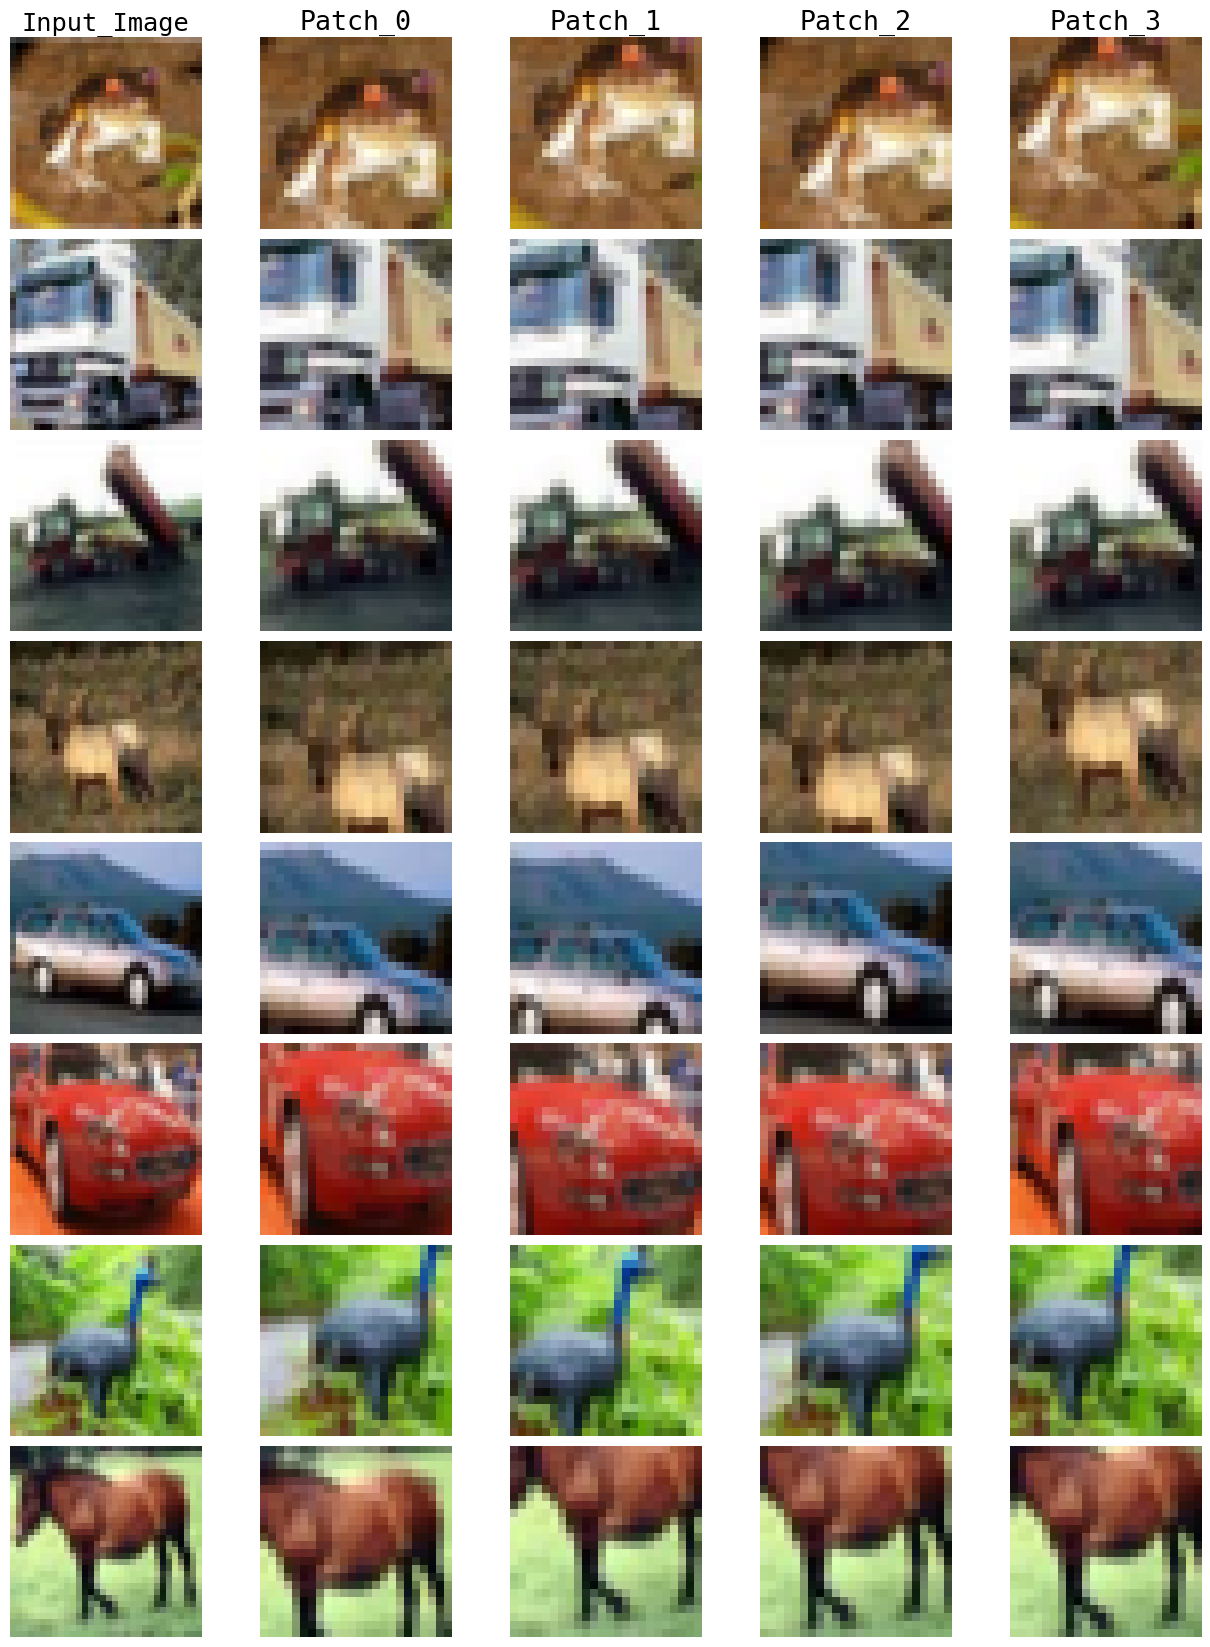

In [8]:
from fastestimator.util import to_number

data4 = pipeline4.get_results()
img = fe.util.ImgData(Input_Image=to_number(data4["x"]), 
                      Patch_0=to_number(data4["x_out"])[:,0,:,:,:], 
                      Patch_1=to_number(data4["x_out"])[:,1,:,:,:], 
                      Patch_2=to_number(data4["x_out"])[:,2,:,:,:], 
                      Patch_3=to_number(data4["x_out"])[:,3,:,:,:])
fig = img.paint_figure()

<a id='ta03to'></a>

## TensorOp
`TensorOps` are used to process tensor data. They are used within a `Network` for graph-based operations. You can go through [Beginner Tutorial 6](../beginner/t06_network.ipynb) to get an overview of `TensorOps` and their usages.

<a id='ta03tl'></a>

### LambdaOp
Just like with NumpyOps, TensorOps have a `LambdaOp` too. The TensorOp version differs in that it should return a tf.Tensor or torch.Tensor rather than an np.ndarray.

In [9]:
from fastestimator.op.tensorop import LambdaOp
import tensorflow as tf

network = fe.Network(ops=[
    LambdaOp(inputs='x', outputs='y', fn=lambda a: a*5)
])

data = network.transform(data={'x':tf.ones((2,2))}, mode='train')
print(f"x: \n{data['x']}")
print(f"y: \n{data['y']}")

x: 
[[1. 1.]
 [1. 1.]]
y: 
[[5. 5.]
 [5. 5.]]


<a id='ta03ct'></a>

### Customizing TensorOps
We can create a custom `TensorOp` using TensorFlow or Pytorch library calls according to our requirements. Below, we showcase a custom `TensorOp` which combines the batch dimension and patch dimension from the output of the above `Pipeline` to make it compatible to the `Network`. `TensorOps` also have a .build() method which will be invoked before the Network runs so that you can make the op compatible with multiple different backends (though you don't have to do this if you don't care about cross-framework compatibility).

In [10]:
from fastestimator.op.tensorop import TensorOp
import tensorflow as tf

class DimensionAdjustment(TensorOp):
    def __init__(self, reduce_dim=[0, 1], inputs=None, outputs=None, mode=None):
        super().__init__(inputs, outputs, mode)
        self.reduce_dim = reduce_dim
        self.reshape_fn = None
    
    def build(self, framework):
        if framework=='tf':
            self.reshape_fn = lambda tensor: tf.reshape(tensor, shape=self._new_shape(tensor))
        elif framework=='torch':
            self.reshape_fn = lambda tensor: torch.reshape(tensor, shape=self._new_shape(tensor))
    
    def forward(self, data, state):
        image, label = data
        image_out = self.reshape_fn(image)
        label_out = self.reshape_fn(label)
        return [image_out, label_out]
    
    def _new_shape(self, data):
        return [-1] + [data.shape[i] for i in range(len(data.shape)) if i not in self.reduce_dim]

In [11]:
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

pipeline5 = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=8,
                       ops=[Minmax(inputs="x", outputs="x"),
                            Patch(height=24, width=24, inputs=["x", "y"], outputs=["x", "y"], 
                                  num_patch=4)])

model = fe.build(model_fn=lambda: LeNet(input_shape=(24, 24, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    DimensionAdjustment(reduce_dim=[0, 1], inputs=["x", "y"], outputs=["x", "y"]),
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

Let's check the dimensions the of Pipeline output and DimensionAdjustment TensorOp output.

In [12]:
data5 = pipeline5.get_results()
result = network.transform(data5, mode="infer")

print(f"Pipeline Output, Image Shape: {data5['x'].shape}, Label Shape: {data5['y'].shape}")
print(f"Result Image Shape: {result['x'].shape}, Label Shape: {result['y'].shape}")

Pipeline Output, Image Shape: torch.Size([8, 4, 24, 24, 3]), Label Shape: torch.Size([8, 4, 1])
Result Image Shape: (32, 24, 24, 3), Label Shape: (32, 1)


`TensorOps` have three other methods which are much less commonly used, but may be overridden if you are working on a complex Op:
1. get_fe_models(self) -> Set
2. get_fe_loss_keys(self) -> Set
3. fe_retain_graph(self, retain) -> bool

If your custom `TensorOp` contains one or more neural network models, you should override the get_fe_models() method to return all of those models. An example where this is done is in our `ModelOp`.

If your custom `TensorOp` is being used to apply a loss value to a model, you should override the get_fe_loss_keys() method to return the string name(s) of all the keys which are being used as losses. An example where this is done is in our `UpdateOp`.

Finally, if your custom Op computes gradients, it should override the fe_retain_graph method such that it can control whether or not your Op will keep the computation graph in memory or erase it after completing its forward pass. An example where this is done is in our `UpdateOp`.

<a id='ta03rae'></a>

## Apphub Examples 

You can find some practical examples of the concepts described here in the following FastEstimator Apphubs:

* [Fast Style Transfer](../../apphub/style_transfer/fst_coco/fst.ipynb)
* [Convolutional Variational AutoEncoder](../../apphub/image_generation/cvae/cvae.ipynb)
* [Semantic Segmentation](../../apphub/semantic_segmentation/unet/unet.ipynb)